RANDOM_SEED 304


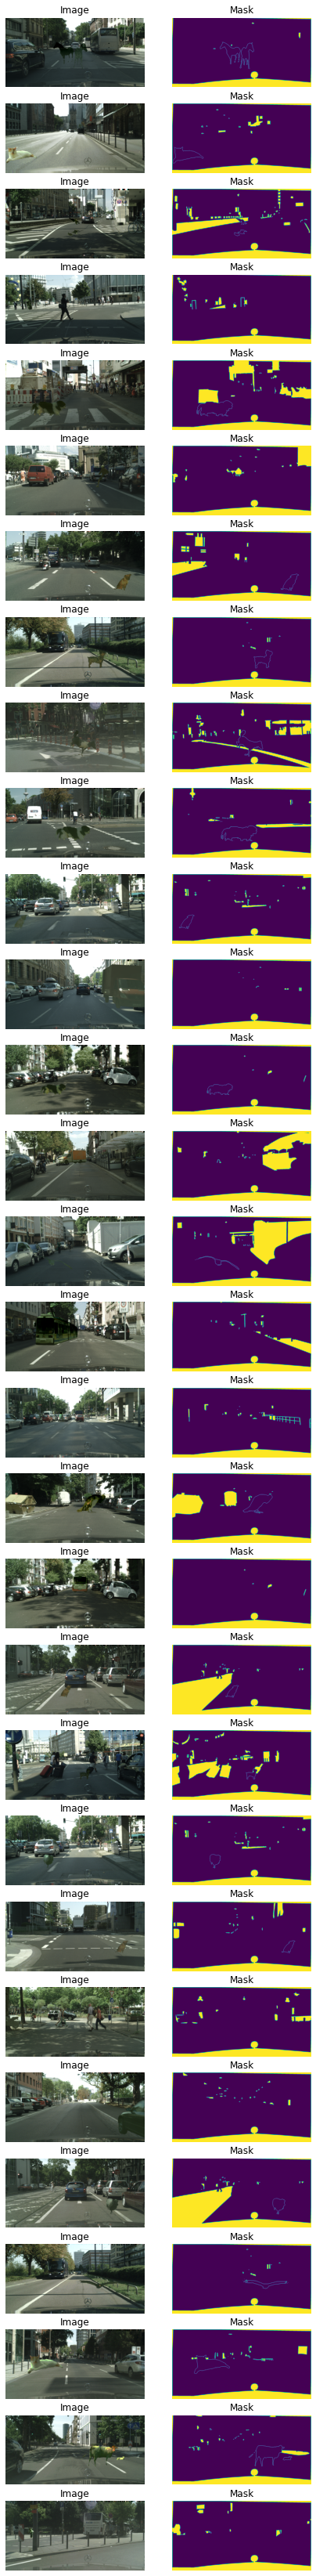

In [1]:
glob_mask = None
import bdlb
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import numpy as np
import random

random_seed = 304
print("RANDOM_SEED", random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

gts = []
input_image = []
def visualize_tfdataset(tfdataset, num_samples):
  """Visualizes `num_samples` from the `tfdataset`."""
  
  fig, axs = plt.subplots(num_samples, 2, figsize=(7, 2*num_samples))
  for i, blob in enumerate(tfdataset.take(num_samples)):
    image = blob['image_left'].numpy()
    
    mask = blob['mask'].numpy()
    axs[i][0].imshow(image.astype('int'))
    axs[i][0].axis("off")
    axs[i][0].set(title="Image")
    # map 255 to 2 such that difference between labels is better visible
    
    
    mask[mask == 255] = 255
    mask[mask == 1] = 1
    
    input_image.append(image)
    gts.append(mask)
    
    axs[i][1].imshow(mask[..., 0])
    axs[i][1].axis("off")
    axs[i][1].set(title="Mask")
    
    
  fig.show()

fs = bdlb.load(benchmark="fishyscapes", download_and_prepare=False)
# load the dataset, there is only a validation dataset
#ds = fs.get_dataset('LostAndFound')
ds = fs.get_dataset('Static')
visualize_tfdataset(ds, 30)

In [2]:
import module.network as network
from module.config import cfg, assert_and_infer_cfg
import module.optimizer as optimizer

import argparse
import torch
import sys


sys.argv = ['hello.py']

parser = argparse.ArgumentParser(description='Semantic Segmentation')
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--arch', type=str, default='network.deepv3.DeepR101V3PlusD_OS8',
                    help='Network architecture. We have DeepSRNX50V3PlusD (backbone: ResNeXt50) \
                    and deepWV3Plus (backbone: WideResNet38).')
parser.add_argument('--dataset', nargs='*', type=str, default='cityscapes',
                    help='a list of datasets; cityscapes')
parser.add_argument('--image_uniform_sampling', action='store_true', default=False,
                    help='uniformly sample images across the multiple source domains')
parser.add_argument('--val_dataset', nargs='*', type=str, default='cityscapes',
                    help='a list consists of cityscapes')
parser.add_argument('--val_interval', type=int, default=100000, help='validation interval')
parser.add_argument('--cv', type=int, default=0,
                    help='cross-validation split id to use. Default # of splits set to 3 in config')
parser.add_argument('--class_uniform_pct', type=float, default=0,
                    help='What fraction of images is uniformly sampled')
parser.add_argument('--class_uniform_tile', type=int, default=1024,
                    help='tile size for class uniform sampling')
parser.add_argument('--coarse_boost_classes', type=str, default=None,
                    help='use coarse annotations to boost fine data with specific classes')

parser.add_argument('--img_wt_loss', action='store_true', default=False,
                    help='per-image class-weighted loss')
parser.add_argument('--cls_wt_loss', action='store_true', default=False,
                    help='class-weighted loss')
parser.add_argument('--batch_weighting', action='store_true', default=False,
                    help='Batch weighting for class (use nll class weighting using batch stats')

parser.add_argument('--jointwtborder', action='store_true', default=False,
                    help='Enable boundary label relaxation')
parser.add_argument('--strict_bdr_cls', type=str, default='',
                    help='Enable boundary label relaxation for specific classes')
parser.add_argument('--rlx_off_iter', type=int, default=-1,
                    help='Turn off border relaxation after specific epoch count')
parser.add_argument('--rescale', type=float, default=1.0,
                    help='Warm Restarts new learning rate ratio compared to original lr')
parser.add_argument('--repoly', type=float, default=1.5,
                    help='Warm Restart new poly exp')

parser.add_argument('--fp16', action='store_true', default=False,
                    help='Use Nvidia Apex AMP')
parser.add_argument('--local_rank', default=0, type=int,
                    help='parameter used by apex library')

parser.add_argument('--sgd', action='store_true', default=True)
parser.add_argument('--adam', action='store_true', default=False)
parser.add_argument('--amsgrad', action='store_true', default=False)
parser.add_argument('--freeze_trunk', action='store_true', default=False)

parser.add_argument('--hardnm', default=0, type=int,
                    help='0 means no aug, 1 means hard negative mining iter 1,' +
                    '2 means hard negative mining iter 2')

parser.add_argument('--trunk', type=str, default='resnet101',
                    help='trunk model, can be: resnet101 (default), resnet50')
parser.add_argument('--max_epoch', type=int, default=180)
parser.add_argument('--max_iter', type=int, default=30000)
parser.add_argument('--max_cu_epoch', type=int, default=100000,
                    help='Class Uniform Max Epochs')
parser.add_argument('--start_epoch', type=int, default=0)
parser.add_argument('--crop_nopad', action='store_true', default=False)
parser.add_argument('--rrotate', type=int,
                    default=0, help='degree of random roate')
parser.add_argument('--color_aug', type=float,
                    default=0.0, help='level of color augmentation')
parser.add_argument('--gblur', action='store_true', default=False,
                    help='Use Guassian Blur Augmentation')
parser.add_argument('--bblur', action='store_true', default=False,
                    help='Use Bilateral Blur Augmentation')
parser.add_argument('--lr_schedule', type=str, default='poly',
                    help='name of lr schedule: poly')
parser.add_argument('--poly_exp', type=float, default=0.9,
                    help='polynomial LR exponent')
parser.add_argument('--bs_mult', type=int, default=2,
                    help='Batch size for training per gpu')
parser.add_argument('--bs_mult_val', type=int, default=1,
                    help='Batch size for Validation per gpu')
parser.add_argument('--crop_size', type=int, default=720,
                    help='training crop size')
parser.add_argument('--pre_size', type=int, default=None,
                    help='resize image shorter edge to this before augmentation')
parser.add_argument('--scale_min', type=float, default=0.5,
                    help='dynamically scale training images down to this size')
parser.add_argument('--scale_max', type=float, default=2.0,
                    help='dynamically scale training images up to this size')
parser.add_argument('--weight_decay', type=float, default=5e-4)
parser.add_argument('--momentum', type=float, default=0.9)
parser.add_argument('--snapshot', type=str, default='data/r101_os8_base_cty.pth')
parser.add_argument('--restore_optimizer', action='store_true', default=False)

parser.add_argument('--city_mode', type=str, default='train',
                    help='experiment directory date name')
parser.add_argument('--date', type=str, default='default',
                    help='experiment directory date name')
parser.add_argument('--exp', type=str, default='default',
                    help='experiment directory name')
parser.add_argument('--tb_tag', type=str, default='',
                    help='add tag to tb dir')
parser.add_argument('--ckpt', type=str, default='logs/ckpt',
                    help='Save Checkpoint Point')
parser.add_argument('--tb_path', type=str, default='logs/tb',
                    help='Save Tensorboard Path')
parser.add_argument('--syncbn', action='store_true', default=True,
                    help='Use Synchronized BN')
parser.add_argument('--dump_augmentation_images', action='store_true', default=False,
                    help='Dump Augmentated Images for sanity check')
parser.add_argument('--test_mode', action='store_true', default=False,
                    help='Minimum testing to verify nothing failed, ' +
                    'Runs code for 1 epoch of train and val')
parser.add_argument('-wb', '--wt_bound', type=float, default=1.0,
                    help='Weight Scaling for the losses')
parser.add_argument('--maxSkip', type=int, default=0,
                    help='Skip x number of  frames of video augmented dataset')
parser.add_argument('--scf', action='store_true', default=False,
                    help='scale correction factor')
parser.add_argument('--dist_url', default='tcp://127.0.0.1:', type=str,
                    help='url used to set up distributed training')
parser.add_argument('--backbone_lr', type=float, default=0.0,
                    help='different learning rate on backbone network')

parser.add_argument('--pooling', type=str, default='mean',
                    help='pooling methods, average is better than max')

parser.add_argument('--ood_dataset_path', type=str,
                    default='/home/nas1_userB/dataset/ood_segmentation/fishyscapes',
                    help='OoD dataset path')

# Anomaly score mode - msp, max_logit, standardized_max_logit
parser.add_argument('--score_mode', type=str, default='mix_test',
                    help='score mode for anomaly [msp, max_logit, standardized_max_logit]')

# Boundary suppression configs
parser.add_argument('--enable_boundary_suppression', type=bool, default=True,
                    help='enable boundary suppression')
parser.add_argument('--boundary_width', type=int, default=4,
                    help='initial boundary suppression width')
parser.add_argument('--boundary_iteration', type=int, default=4,
                    help='the number of boundary iterations')

# Dilated smoothing configs
parser.add_argument('--enable_dilated_smoothing', type=bool, default=True,
                    help='enable dilated smoothing')
parser.add_argument('--smoothing_kernel_size', type=int, default=7,
                    help='kernel size of dilated smoothing')
parser.add_argument('--smoothing_kernel_dilation', type=int, default=6,
                    help='kernel dilation rate of dilated smoothing')

args = parser.parse_args()

In [3]:
# Enable CUDNN Benchmarking optimization
#torch.backends.cudnn.benchmark = True
import time

args.world_size = 1

print(f'World Size: {args.world_size}')
torch.cuda.set_device(args.local_rank)
print('My Rank:', args.local_rank)
# Initialize distributed communication
args.dist_url = args.dist_url + str(8000 + (int(time.time()%1000))//10)

torch.distributed.init_process_group(backend='nccl',
                                     init_method=args.dist_url,
                                     world_size=args.world_size,
                                     rank=args.local_rank)

def get_net():
    """
    Main Function
    """
    # Set up the Arguments, Tensorboard Writer, Dataloader, Loss Fn, Optimizer
    assert_and_infer_cfg(args)

    net = network.get_net(args, criterion=None, criterion_aux=None)

    net = torch.nn.SyncBatchNorm.convert_sync_batchnorm(net)
    net = network.warp_network_in_dataparallel(net, args.local_rank)

    import module
    import os
    
    if args.snapshot:
        epoch, mean_iu = optimizer.load_weights(net, None, None,
                            os.path.dirname(os.path.abspath(module.__file__))+'/'+args.snapshot, args.restore_optimizer)
        print(f"Loading completed. Epoch {epoch} and mIoU {mean_iu}")
    else:
        raise ValueError(f"snapshot argument is not set!")

    class_mean = np.load(os.path.dirname(os.path.abspath(module.__file__))+'/'+f'data/cityscapes_mean_reported.npy', allow_pickle=True)
    class_var = np.load(os.path.dirname(os.path.abspath(module.__file__))+'/'+f'data/cityscapes_var_reported.npy', allow_pickle=True)
    net.module.set_statistics(mean=class_mean.item(), var=class_var.item())

    torch.cuda.empty_cache()
    net.eval()

    return net
net = get_net()

World Size: 1
My Rank: 0
Using pytorch sync batch norm
selem:

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')
selem_dilation:

tensor([[0., 1., 0.],
        [1., 1., 1.],
        [0., 1., 0.]], device='cuda:0')
dilation kernel at 1:

tensor([[0., 1., 0.],
        [1., 1., 1.],
        [0., 1., 0.]], device='cuda:0')
dilation kernel at 2:

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0.]], device='cuda:0')
dilation kernel at 3:

tensor([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
dilation kernel at 4:

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1.,

In [4]:
np.var(np.array( [0, 1, 0, 0, 0]))

0.16000000000000006

In [5]:
features_t = []
def hook_t(module, input, output):
    features_t.append(output.cuda())

net.module.final1.register_forward_hook(hook_t)
net.module.final2.register_forward_hook(hook_t)

In [6]:
val =np.array(gts)[:,:,:,0]

In [7]:
from collections import namedtuple

# Based on https://github.com/mcordts/cityscapesScripts
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                 'has_instances', 'ignore_in_eval', 'color'])
classes = [
    CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    #CityscapesClass('license plate',        250, 255, 'vehicle', 7, False, True, (0, 0, 0)),
]
train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color.append([0, 0, 0])
train_id_to_color = np.array(train_id_to_color)
    
def decode_target(mask):
    """decode semantic mask to RGB image"""
    return train_id_to_color[mask]


In [8]:
import argparse
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import cv2
import numpy as np
import os
import glob
import shutil
import time
from torchvision.models import resnet18, resnet101
from PIL import Image
from sklearn.metrics import roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_train = [0.485, 0.456, 0.406]
std_train = [0.229, 0.224, 0.225]



def val_data_transforms(load_size=256, mean_train=mean_train, std_train=std_train):
    data_transforms = transforms.Compose([
            #transforms.Resize((load_size, load_size), Image.ANTIALIAS),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_train,
                                std=std_train)
            ])
    return data_transforms

num = 0
var_n = []
var_a = []
sml_n = []
sml_a = []
esm_n = []
esm_a = []
def estimator(image):
    global num
    global features_t

    features_t = []
    """Assigns a random uncertainty per pixel."""
    val_data_transform = val_data_transforms(mean_train=mean_train, std_train=std_train)
    test_img = Image.fromarray(np.array(image))
    test_img = val_data_transform(test_img)
    test_img = torch.unsqueeze(test_img, 0).to(device)

    with torch.set_grad_enabled(False):
        out, out2, max_logit, variance, mixed, SML = net(test_img)
   
    logit2, predction01 = features_t[1].detach().cpu().max(1)
    
    colorized_preds = decode_target(predction01[0, ...]).astype('uint8') # To RGB images, (N, H, W, 3), ranged 0~255, numpy array
    colorized_preds = Image.fromarray(colorized_preds) # to PIL Image

    new_logit = -out2.clone()
    
    new_logit = new_logit.unsqueeze(1)
    new_logit = F.interpolate(new_logit, size=(256, 512), mode='bilinear', align_corners=True)
    new_logit = new_logit.squeeze(1)
    feats =  features_t[0]
    new_logit -= torch.min(new_logit)
    new_logit /= torch.max(new_logit)
    
    

    maps = torch.ones(1, 256, 512)
    
    for i in range(3):
        feats = (((1-new_logit.cuda()) * feats) + ((new_logit.cuda()) * torch.max(feats) ))
        output = net.module.final2(feats)
        anomaly_score, _ = output.detach().max(1)
        new_logit = anomaly_score.detach().cpu()
        
        new_logit = new_logit.detach().cpu()[0]
        new_logit -= torch.min(new_logit)
        new_logit /= torch.max(new_logit)
        
        maps[:] = new_logit
        
    new_logit = maps
    new_logit = new_logit.unsqueeze(1)
    new_logit = F.interpolate(new_logit, size=(1024, 2048), mode='bilinear', align_corners=True)
    new_logit = new_logit.squeeze(1)
    
    out3 = -out2.detach().cpu()[0]

    new_logit = new_logit[0]
    new_logit -= torch.min(new_logit)
    new_logit /= torch.max(new_logit)
    
    norm_logit = new_logit

    final_output = out3 * (1-norm_logit)
    
    #import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors


    def make_colormap(seq):
        """Return a LinearSegmentedColormap
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
        and in the interval (0,1).
        """
        seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
        return mcolors.LinearSegmentedColormap('CustomMap', cdict)


    c = mcolors.ColorConverter().to_rgb
    rvb = make_colormap(
        [c('blue'), c('blue'), 0.33, c('blue'), c('yellow'), 0.50 ,c('yellow'), c('orange'), 0.90 ,c('orange'), c('red'), 0.95, c('red')])
    
    def get_imft(img, feature):
        import requests, PIL.Image, io, numpy as np, matplotlib.pyplot as plt
        # load some image
        # load or compute some features
        h, w, _ = img.shape
        mg = np.mgrid[:h, :w]
        # compute heated image
        #print(feature)
        feature = (feature - np.amin(feature)).astype(np.float32) / (np.amax(feature) - np.amin(feature)).astype(np.float32) + 0.0001
        feature[[(gts[num]==255)[..., 0]]] = 0
        #print(feature)
        alpha = 0.5; img_feature = ((
            rvb(
                feature
            )[:, :, :3] * 255
        ) * alpha + img * (1 - alpha)).astype(np.uint8)
        
        img_feature = img_feature[100:-100,400:-400,:]
        return img_feature 

    print(input_image[num].shape)
    print(out2.shape)
    print(variance.shape)
    
    
    
    colorized_preds = colorized_preds.resize((input_image[num].shape[1],input_image[num].shape[0]), Image.NEAREST)
    #Image.fromarray(input_image[num][100:-100,400:-400,:]).save("fig/"+str(num) + "_origin.PNG", "PNG")
    (colorized_preds.crop((400, 100, input_image[num].shape[1] - 400, input_image[num].shape[0] - 100))).save("fig/"+str(num) + "_segment.PNG", "PNG")
    #Image.fromarray(get_imft(input_image[num], np.array(-out2[0,...].detach().cpu()))).save("fig/"+str(num) + "_SML.PNG", "PNG")
    #Image.fromarray(get_imft(input_image[num], np.array(-variance[0,...].detach().cpu()))).save("fig/"+str(num) + "_Var.PNG", "PNG")
    #Image.fromarray(get_imft(input_image[num], np.array(final_output[...].detach().cpu()))).save("fig/"+str(num) + "_Ours.PNG", "PNG")
    
    num += 1
    
    del out
    return torch.tensor(final_output.detach().cpu())

metrics = fs.evaluate(estimator, ds.take(30))

#plt.plot(metrics['recall'], metrics['precision'])
#plt.xlabel('recall')
#plt.ylabel('precision')
#plt.show()
print("AP: " + str(metrics['AP']) + " FPR95: " + str(metrics['FPR@95%TPR']) +  " auroc: " + str(metrics['auroc']))

0it [00:00, ?it/s]hello.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
1it [00:00,  1.13it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


2it [00:01,  1.37it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


3it [00:01,  1.61it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


4it [00:01,  1.83it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


5it [00:02,  2.03it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


6it [00:02,  2.19it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


7it [00:03,  2.32it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


8it [00:03,  2.43it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


9it [00:03,  2.51it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


10it [00:04,  2.57it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


11it [00:04,  2.61it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


12it [00:04,  2.64it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


13it [00:05,  2.66it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


14it [00:05,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


15it [00:06,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


16it [00:06,  2.70it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


17it [00:06,  2.71it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


18it [00:07,  2.71it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


19it [00:07,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


20it [00:07,  2.69it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


21it [00:08,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


22it [00:08,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


23it [00:09,  2.66it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


24it [00:09,  2.67it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


25it [00:09,  2.65it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


26it [00:10,  2.67it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


27it [00:10,  2.68it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


28it [00:10,  2.55it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


29it [00:11,  2.58it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


30it [00:11,  2.56it/s]

(1024, 2048, 3)
torch.Size([1, 1024, 2048])
torch.Size([1, 1024, 2048])


AP: 0.54066156612578 FPR95: 0.39074410897306594 auroc: 0.9460511288048178


In [12]:
#import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
def make_colormap(seq):
        """Return a LinearSegmentedColormap
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
        and in the interval (0,1).
        """
        seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
        return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('blue'), c('blue'), 0.33, c('blue'), c('yellow'), 0.50 ,c('yellow'), c('orange'), 0.90 ,c('orange'), c('red'), 0.95, c('red')])



In [17]:
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=rvb)
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

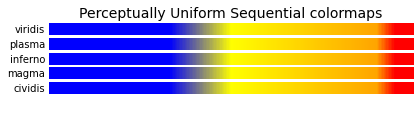

In [18]:
plot_color_gradients('Perceptually Uniform Sequential',
                     ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

In [13]:
rvb

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(
        x=["hey", 1, 2],
        y=[6, 10, 2],
        error_y=dict(
            type='percent', # value of error bar given as percentage of y value
            value=50,
            visible=True)
    ))
fig.show()

In [ ]:
from collections import namedtuple

# Based on https://github.com/mcordts/cityscapesScripts
CityscapesClass = namedtuple('CityscapesClass', ['name', 'id', 'train_id', 'category', 'category_id',
                                                 'has_instances', 'ignore_in_eval', 'color'])
classes = [
    CityscapesClass('unlabeled',            0, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('ego vehicle',          1, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('out of roi',           3, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('static',               4, 255, 'void', 0, False, True, (0, 0, 0)),
    CityscapesClass('dynamic',              5, 255, 'void', 0, False, True, (111, 74, 0)),
    CityscapesClass('ground',               6, 255, 'void', 0, False, True, (81, 0, 81)),
    CityscapesClass('road',                 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    CityscapesClass('sidewalk',             8, 1, 'flat', 1, False, False, (244, 35, 232)),
    CityscapesClass('parking',              9, 255, 'flat', 1, False, True, (250, 170, 160)),
    CityscapesClass('rail track',           10, 255, 'flat', 1, False, True, (230, 150, 140)),
    CityscapesClass('building',             11, 2, 'construction', 2, False, False, (70, 70, 70)),
    CityscapesClass('wall',                 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    CityscapesClass('fence',                13, 4, 'construction', 2, False, False, (190, 153, 153)),
    CityscapesClass('guard rail',           14, 255, 'construction', 2, False, True, (180, 165, 180)),
    CityscapesClass('bridge',               15, 255, 'construction', 2, False, True, (150, 100, 100)),
    CityscapesClass('tunnel',               16, 255, 'construction', 2, False, True, (150, 120, 90)),
    CityscapesClass('pole',                 17, 5, 'object', 3, False, False, (153, 153, 153)),
    CityscapesClass('polegroup',            18, 255, 'object', 3, False, True, (153, 153, 153)),
    CityscapesClass('traffic light',        19, 6, 'object', 3, False, False, (250, 170, 30)),
    CityscapesClass('traffic sign',         20, 7, 'object', 3, False, False, (220, 220, 0)),
    CityscapesClass('vegetation',           21, 8, 'nature', 4, False, False, (107, 142, 35)),
    CityscapesClass('terrain',              22, 9, 'nature', 4, False, False, (152, 251, 152)),
    CityscapesClass('sky',                  23, 10, 'sky', 5, False, False, (70, 130, 180)),
    CityscapesClass('person',               24, 11, 'human', 6, True, False, (220, 20, 60)),
    CityscapesClass('rider',                25, 12, 'human', 6, True, False, (255, 0, 0)),
    CityscapesClass('car',                  26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    CityscapesClass('truck',                27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    CityscapesClass('bus',                  28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    CityscapesClass('caravan',              29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    CityscapesClass('trailer',              30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    CityscapesClass('train',                31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    CityscapesClass('motorcycle',           32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    CityscapesClass('bicycle',              33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    CityscapesClass('license plate',        -1, 255, 'vehicle', 7, False, True, (0, 0, 142)),
    #CityscapesClass('license plate',        250, 255, 'vehicle', 7, False, True, (0, 0, 0)),
]
train_id_to_color = [c.color for c in classes if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color.append([0, 0, 0])
train_id_to_color = np.array(train_id_to_color)
    
def decode_target(mask):
    """decode semantic mask to RGB image"""
    return train_id_to_color[mask]


In [ ]:
names = [x.name for x in classes if x.train_id!=255]

In [ ]:
names

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(
    y=[3, 1, 4],
    x=names))

fig.update_layout(
    title={
        'text': "Plot Title",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [ ]:
import requests, PIL.Image, io, numpy as np, matplotlib.pyplot as plt
# load some image
img = np.array(PIL.Image.open(io.BytesIO(requests.get('https://i.stack.imgur.com/vPlCG.jpg').content)))
# load or compute some features
h, w, _ = img.shape
mg = np.mgrid[:h, :w]
feature = mg[0].astype(np.float64) * mg[1].astype(np.float64)
feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
# compute heated image
alpha = 0.5; img_feature = ((plt.cm.jet(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
# show images
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img)
axs[0, 1].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
axs[1, 0].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
axs[1, 1].remove()
plt.show()

In [ ]:
import seaborn as sns
sns.palplot(sns.diverging_palette(240, 10, n=81))
sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)

In [ ]:
sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots()
sns.heatmap(df, ax=ax, cbar_kws={'label': 'My Label'})
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(PercentFormatter(1, 0))

In [ ]:
import matplotlib
myColors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
rvb = make_colormap(
    [c('blue'), c('blue'), 0.33, c('blue'), c('lightgreen'), 0.80 ,c('lightgreen'), c('red'), 0.99, c('red')])
N = 1000
array_dg = np.random.uniform(0, 10, size=(N, 2))
colors = np.random.uniform(-2, 2, size=(N,))
plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=rvb)
plt.colorbar()
plt.show()

In [ ]:
import requests, PIL.Image, io, numpy as np, matplotlib.pyplot as plt
# load some image
img = np.array(PIL.Image.open(io.BytesIO(requests.get('https://i.stack.imgur.com/vPlCG.jpg').content)))
# load or compute some features
h, w, _ = img.shape
mg = np.mgrid[:h, :w]
feature = mg[0].astype(np.float64) * mg[1].astype(np.float64)
feature = (255.5 * feature / np.amax(feature)).astype(np.uint8)
# compute heated image
alpha = 0.5; img_feature = ((rvb(feature)[:, :, :3] * 255) * alpha + img * (1 - alpha)).astype(np.uint8)
# show images
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(img)
axs[0, 1].imshow(feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
axs[1, 0].imshow(img_feature, alpha = 1., interpolation = 'gaussian', cmap = plt.cm.jet)
axs[1, 1].remove()
plt.show()

In [ ]:
(gts[num]).shape